# DCGAN

## dataset
- [ ] mnist
- [ ] fashion mnist
- [ ] celebA

## model architecture for stable DC GANs
- [ ] Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- [ ] Use Batch-norm for generator and discriminator.
- [ ] Remove fully connected layers.
- [ ] Use Relu activation in generator for all layers except for the output, which uses Tanh.
- [ ] Use leakyRelu activation in the discriminator for all layers.






# installation

In [1]:
!pip install tensorflow==2.0.0-beta0 
# !conda install -y -q seaborna


     |████████████████████████████████| 87.9MB 1.2MB/s 
     |████████████████████████████████| 501kB 39.5MB/s 
     |████████████████████████████████| 3.1MB 30.1MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


# Imports

In [2]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
import numpy as np
print(np.__version__)
keras = tf.keras

K = keras.backend


2.0.0-beta0
0.9.0
1.16.5


# Configurations

In [0]:
batch_size = 128
epochs = 50
noise_dim = 100

# datasets

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


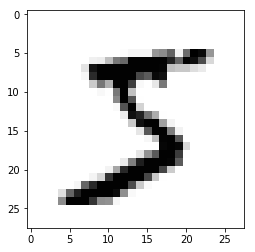

(60000, 28, 28, 1)
<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [8]:
dataset = keras.datasets.mnist.load_data()

X_train, X_test = dataset[0][0], dataset[1][0]
Y_train, Y_test = dataset[0][1], dataset[1][1]

del(dataset)

print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

plt.imshow(X_train[0], cmap="Greys")
plt.show()

X_train = X_train.reshape([*X_train.shape] + [1]).astype('float32')
X_test = X_test.reshape([*X_test.shape] + [1]).astype('float32')
print(X_train.shape)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

data = tf.data.Dataset.from_tensor_slices(X_train)

data = data.shuffle(batch_size * 10).batch(batch_size).prefetch(batch_size * 5)
print(data)

# DECONVOLUTION MODEL (GENERATOR)

- INPUT : a random noise with dimension of (100,)
- OUTPUT : generated image with dimension of (28, 28, 1)


In [0]:
def build_generator():
    
    model = keras.models.Sequential()
    
    layers_kwargs = {
        'kernel_initializer': keras.initializers.TruncatedNormal(seed=0),
        'activation': 'relu',

    }
    
    model.add(keras.layers.Dense(units=256*7*7, input_shape=(100,), **layers_kwargs))
    model.add(keras.layers.Reshape(target_shape=[7, 7, 256]))
    
    layers_kwargs['padding'] = 'same'
    
    model.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                          strides=(1, 1), **layers_kwargs))
    model.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                          strides=(2, 2), **layers_kwargs))
    # model.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=(5, 5),
    #                                       strides=(2, 2), **layers_kwargs))

    layers_kwargs['activation'] = 'tanh'
    
    model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5),
                                          strides=(2, 2), **layers_kwargs))
    
    return model

# DISCRIMINATOR MODEL

- INPUT : a image with 28x28x1 size.
- OUTPUT : the probability whether the image is fake or real

In [0]:
def build_discriminator():
    
    model = keras.models.Sequential()
    
    layers_kwargs = {
        'kernel_size': (5, 5),
        'strides': (2, 2),
        'padding': 'same',
        'activation': 'relu',
        'kernel_initializer': keras.initializers.TruncatedNormal()
    }
    
    model.add(keras.layers.Conv2D(filters=64, input_shape=(28, 28, 1), **layers_kwargs))
    model.add(keras.layers.Conv2D(filters=128, **layers_kwargs))
#     model.add(keras.layers.Conv2D(filters=))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer=keras.initializers.TruncatedNormal()))
    return model

# Losses



$$\min_{\theta_d}\max_{\theta_g} E_{x\sim p_{data}}\log D(x) + E_{z\sim p_{z}}\log(1 - D(G(z)))$$

$$p_z \sim 표준정규분포$$ 

In [0]:
def generator_loss(y_pred):
    y_true = keras.backend.ones_like(y_pred)
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy, axis=0)

In [0]:
def discriminator_loss(y_pred, x):
    if x:
        y_true = keras.backend.ones_like(y_pred)
    else:
        y_true = keras.backend.zeros_like(y_pred)
    
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy)

In [0]:
opt_g = keras.optimizers.Adam(learning_rate=0.0001)
opt_d = keras.optimizers.Adam(learning_rate=0.0001)

In [54]:
generator = build_generator()
generator.summary()
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 7, 7, 128)         819328    
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 7, 7, 64)          204864    
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 14, 14, 32)        51232     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 28, 28, 1)         801       
Total params: 2,343,169
Trainable params: 2,343,169
Non-trainable params: 0
____________________________________________

In [0]:
def print_tensors(tensors):
    for each in tensors:
        print(f'{each.name} {each.shape}')

In [0]:
# @tf.function
def train_step(real_data):
    z = np.random.randn(batch_size, noise_dim)
    
    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        Gz = generator(inputs=z)
        Dz = discriminator(inputs=Gz)
        Dx = discriminator(inputs=real_data)
        
        loss_g = generator_loss(Dz)
        loss_d = discriminator_loss(Dz, x=False)
        loss_d += discriminator_loss(Dx, x=True)
        
        print(f'losses: {loss_g}, {loss_d}')
        print(loss_g.shape, loss_d.shape)
        
    grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
    grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)
    opt_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    opt_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    
    return Gz
    
    
    
    
    

In [0]:
def imshow(tensor):
    img = tf.reshape(tensor, shape=[28, 28])
    plt.imshow(img.numpy(), cmap='gray')
    plt.show()

0
losses: 0.5566619038581848, 1.483375072479248
() ()
-------------------- 0 --------------------


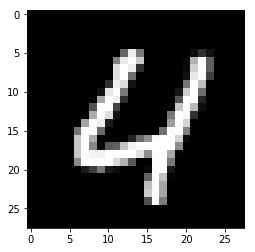

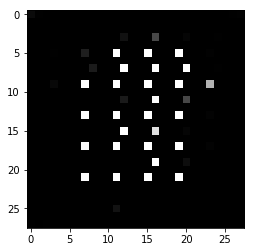

losses: 0.5067862272262573, 1.4418245553970337
() ()
losses: 0.49809008836746216, 1.4032484292984009
() ()
losses: 0.4380698502063751, 1.4220690727233887
() ()
losses: 0.45542752742767334, 1.3095349073410034
() ()
losses: 0.42840659618377686, 1.3053816556930542
() ()
losses: 0.4223041534423828, 1.2760393619537354
() ()
losses: 0.46734708547592163, 1.1661609411239624
() ()
losses: 0.4530823230743408, 1.1747561693191528
() ()
losses: 0.4754675626754761, 1.1190366744995117
() ()
losses: 0.47792378067970276, 1.088104248046875
() ()
losses: 0.4794307053089142, 1.0680482387542725
() ()
losses: 0.5123908519744873, 1.014410138130188
() ()
losses: 0.5347335338592529, 0.9676162600517273
() ()
losses: 0.5412826538085938, 0.9532569646835327
() ()
losses: 0.5185108780860901, 0.9876853227615356
() ()
losses: 0.5415656566619873, 0.9529926776885986
() ()
losses: 0.4904841482639313, 1.0175381898880005
() ()
losses: 0.4601696729660034, 1.0765854120254517
() ()
losses: 0.45849698781967163, 1.074720263481

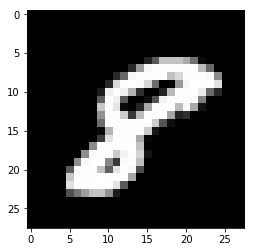

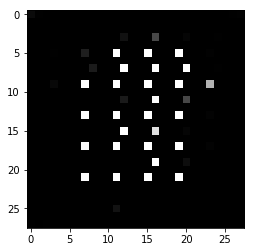

losses: 1.4583299160003662, 0.4652784466743469
() ()
losses: 1.4077895879745483, 0.4550299644470215
() ()
losses: 1.38092041015625, 0.4665936827659607
() ()
losses: 1.3372290134429932, 0.5220987796783447
() ()
losses: 1.3023114204406738, 0.5130422115325928
() ()
losses: 1.3030970096588135, 0.5375612378120422
() ()
losses: 1.2967727184295654, 0.5728614926338196
() ()
losses: 1.2952532768249512, 0.5607576370239258
() ()
losses: 1.3149653673171997, 0.6038711667060852
() ()
losses: 1.3242323398590088, 0.5802047848701477
() ()
losses: 1.3413869142532349, 0.6605547070503235
() ()
losses: 1.3140960931777954, 0.5872925519943237
() ()
losses: 1.2502126693725586, 0.6843464374542236
() ()
losses: 1.109602451324463, 0.7262988686561584
() ()
losses: 0.9494109749794006, 0.8499313592910767
() ()
losses: 0.9036756753921509, 0.9340436458587646
() ()
losses: 0.8877840042114258, 0.863588809967041
() ()
losses: 0.8884183168411255, 0.9284064173698425
() ()
losses: 0.9022257328033447, 0.8692370653152466
() 

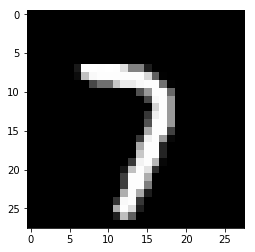

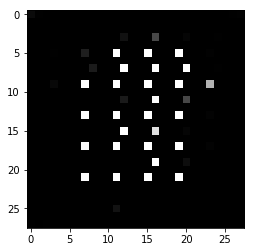

losses: 2.276618003845215, 0.18068072199821472
() ()
losses: 2.311048746109009, 0.17803052067756653
() ()
losses: 2.3512864112854004, 0.1873844861984253
() ()
losses: 2.4594483375549316, 0.19126293063163757
() ()
losses: 2.596437931060791, 0.14763504266738892
() ()
losses: 2.7511372566223145, 0.09092974662780762
() ()
losses: 2.8733930587768555, 0.13689783215522766
() ()
losses: 2.9889965057373047, 0.14038774371147156
() ()
losses: 3.080608367919922, 0.15762734413146973
() ()
losses: 3.1528985500335693, 0.14665213227272034
() ()
losses: 3.1961450576782227, 0.1462906450033188
() ()
losses: 3.2248919010162354, 0.13739052414894104
() ()
losses: 3.2099266052246094, 0.07601013779640198
() ()
losses: 3.1852736473083496, 0.11262772977352142
() ()
losses: 3.041191577911377, 0.1085420548915863
() ()
losses: 2.839834213256836, 0.15341752767562866
() ()
losses: 2.524136543273926, 0.12238825857639313
() ()
losses: 2.255248546600342, 0.16689497232437134
() ()
losses: 2.187770366668701, 0.1708756983

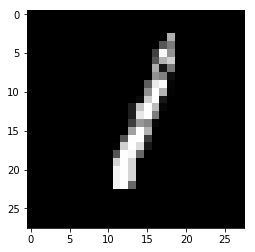

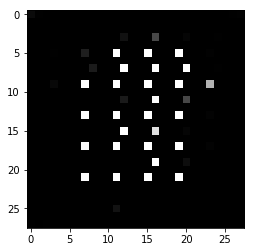

losses: 3.710493564605713, 0.048720963299274445
() ()
losses: 3.7752227783203125, 0.040641359984874725
() ()
losses: 3.8204269409179688, 0.03408592939376831
() ()
losses: 3.834338665008545, 0.05709477514028549
() ()
losses: 3.7518670558929443, 0.0361110121011734
() ()
losses: 3.699488639831543, 0.04336092621088028
() ()
losses: 3.670680522918701, 0.044236086308956146
() ()
losses: 3.7117762565612793, 0.07185687869787216
() ()
losses: 3.7467403411865234, 0.04533369466662407
() ()
losses: 3.7851085662841797, 0.03648470342159271
() ()
losses: 3.8032455444335938, 0.046309299767017365
() ()
losses: 3.8327207565307617, 0.07805197685956955
() ()
losses: 3.8480618000030518, 0.08033853769302368
() ()
losses: 3.865558624267578, 0.04391957446932793
() ()
losses: 3.870337724685669, 0.0395817831158638
() ()
losses: 3.871453285217285, 0.03272140771150589
() ()
losses: 3.8840646743774414, 0.0848967656493187
() ()
losses: 3.831070899963379, 0.06593309342861176
() ()
losses: 3.7979235649108887, 0.03037

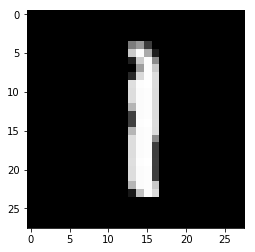

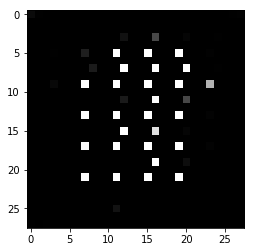

losses: 2.473267078399658, 0.13752880692481995
() ()
losses: 2.572273015975952, 0.12955418229103088
() ()
losses: 2.6643028259277344, 0.10133078694343567
() ()
losses: 2.646638870239258, 0.08208553493022919
() ()
losses: 2.908688545227051, 0.09308177977800369
() ()
losses: 3.038902521133423, 0.08662868291139603
() ()
losses: 3.291147232055664, 0.17972533404827118
() ()
losses: 3.46140193939209, 0.24484795331954956
() ()
losses: 3.4429659843444824, 0.18794596195220947
() ()
losses: 3.2860946655273438, 0.11434906721115112
() ()
losses: 3.243837833404541, 0.09668827801942825
() ()
losses: 3.224700450897217, 0.17325910925865173
() ()
losses: 3.1501715183258057, 0.2047216147184372
() ()
losses: 2.9929845333099365, 0.09704165905714035
() ()
losses: 2.8786468505859375, 0.07509754598140717
() ()
losses: 2.8422672748565674, 0.13110123574733734
() ()
losses: 2.797508716583252, 0.07925206422805786
() ()
losses: 2.771202802658081, 0.13211016356945038
() ()
losses: 2.799020767211914, 0.105941295623

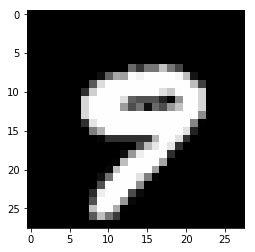

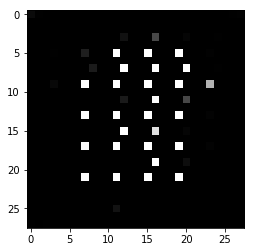

losses: 4.096966743469238, 0.05741239711642265
() ()
losses: 3.9939236640930176, 0.026046983897686005
() ()
losses: 3.9445719718933105, 0.03028854727745056
() ()
losses: 3.897902011871338, 0.03542681783437729
() ()
losses: 3.865630865097046, 0.04055452719330788
() ()
losses: 3.841583251953125, 0.024349551647901535
() ()
losses: 3.8622379302978516, 0.03320583328604698
() ()
losses: 3.903501510620117, 0.05737776681780815
() ()
losses: 3.907437324523926, 0.03180060535669327
() ()
losses: 3.946683406829834, 0.028427956625819206
() ()
losses: 3.9787259101867676, 0.027006927877664566
() ()
losses: 4.047647476196289, 0.037247806787490845
() ()
losses: 4.114426136016846, 0.028538113459944725
() ()
losses: 4.1886820793151855, 0.02801961824297905
() ()
losses: 4.275883197784424, 0.02056431956589222
() ()
losses: 4.3458991050720215, 0.021845493465662003
() ()
losses: 4.450244903564453, 0.015496157109737396
() ()
losses: 4.539925575256348, 0.022819511592388153
() ()
losses: 4.62473201751709, 0.015

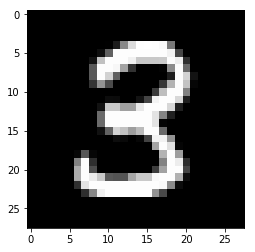

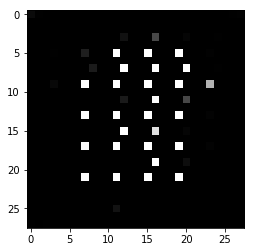

losses: 4.585107326507568, 0.01308513805270195
() ()
losses: 4.63092565536499, 0.017597272992134094
() ()
losses: 4.686663627624512, 0.024388302117586136
() ()
losses: 4.734323501586914, 0.010052533820271492
() ()
losses: 4.787604331970215, 0.010730473324656487
() ()
losses: 4.844145774841309, 0.08571470528841019
() ()
losses: 4.844358444213867, 0.008694189600646496
() ()
losses: 4.865002155303955, 0.013528527691960335
() ()
losses: 4.882943630218506, 0.050522319972515106
() ()
losses: 4.851795196533203, 0.030021172016859055
() ()
losses: 4.802501201629639, 0.010923396795988083
() ()
losses: 4.772452354431152, 0.01130203902721405
() ()
losses: 4.757721900939941, 0.05957888811826706
() ()
losses: 4.682368278503418, 0.01519251149147749
() ()
losses: 4.631596565246582, 0.01193895936012268
() ()
losses: 4.599252700805664, 0.12419834733009338
() ()
losses: 4.464890480041504, 0.02136881649494171
() ()
losses: 4.3363752365112305, 0.014151937328279018
() ()
losses: 4.250528335571289, 0.0183232

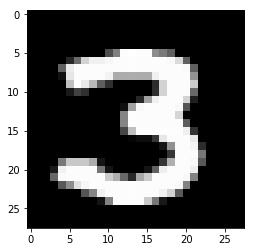

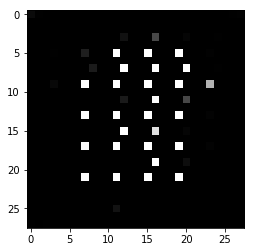

losses: 5.364531517028809, 0.005606445483863354
() ()
losses: 5.396966934204102, 0.010252691805362701
() ()
losses: 5.3957366943359375, 0.031302303075790405
() ()
losses: 5.356241226196289, 0.012624669820070267
() ()
losses: 5.35333251953125, 0.005478980951011181
() ()
losses: 5.364861965179443, 0.007667349651455879
() ()
losses: 5.386419296264648, 0.011967778205871582
() ()
losses: 5.414188385009766, 0.08774298429489136
() ()
losses: 5.327601432800293, 0.006753406021744013
() ()
losses: 5.252993106842041, 0.010202743113040924
() ()
losses: 5.190988540649414, 0.00790533609688282
() ()
losses: 5.1431097984313965, 0.00959980208426714
() ()
losses: 5.095284461975098, 0.012706607580184937
() ()
losses: 5.04363489151001, 0.029271630570292473
() ()
losses: 4.963274955749512, 0.013584179803729057
() ()
losses: 4.911055564880371, 0.00764920748770237
() ()
losses: 4.896207332611084, 0.009168456308543682
() ()
losses: 4.85842227935791, 0.008808265440165997
() ()
losses: 4.857760429382324, 0.0081

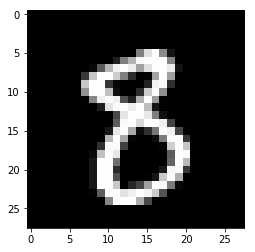

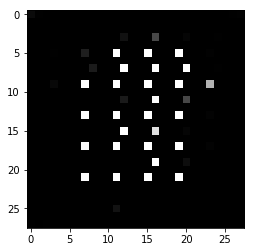

losses: 5.419317245483398, 0.006022206041961908
() ()
losses: 5.447019100189209, 0.010954715311527252
() ()
losses: 5.47088623046875, 0.0072778332978487015
() ()
losses: 5.497527122497559, 0.005949851591140032
() ()
losses: 5.529935836791992, 0.00770403491333127
() ()
losses: 5.563394546508789, 0.005708792246878147
() ()
losses: 5.600760459899902, 0.009644035249948502
() ()
losses: 5.632321357727051, 0.005730208940804005
() ()
losses: 5.667412281036377, 0.026617471128702164
() ()
losses: 5.654649257659912, 0.004285123664885759
() ()
losses: 5.652029037475586, 0.013041188940405846
() ()
losses: 5.6378631591796875, 0.012333880178630352
() ()
losses: 5.613321781158447, 0.026664365082979202
() ()
losses: 5.5510969161987305, 0.0184415765106678
() ()
losses: 5.470821380615234, 0.03438504785299301
() ()
losses: 5.349437713623047, 0.011001160368323326
() ()
losses: 5.240204334259033, 0.007685510441660881
() ()
losses: 5.152902603149414, 0.0068742660805583
() ()
losses: 5.091020107269287, 0.016

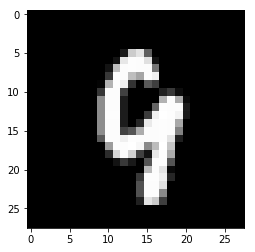

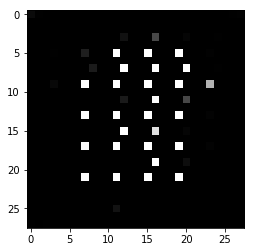

losses: 4.556610107421875, 0.019299495965242386
() ()
losses: 4.433801651000977, 0.016415169462561607
() ()
losses: 4.353757858276367, 0.02277810126543045
() ()
losses: 4.300032615661621, 0.015943028032779694
() ()
losses: 4.293346881866455, 0.014663857407867908
() ()
losses: 4.334250450134277, 0.01721029169857502
() ()
losses: 4.409264087677002, 0.02149752527475357
() ()
losses: 4.494336128234863, 0.01258131768554449
() ()
losses: 4.608191013336182, 0.011403210461139679
() ()
losses: 4.743015289306641, 0.010733423754572868
() ()
losses: 4.891125202178955, 0.00833640806376934
() ()
losses: 5.0492963790893555, 0.014099841006100178
() ()
losses: 5.1961469650268555, 0.00634114071726799
() ()
losses: 5.345480442047119, 0.008703256957232952
() ()
losses: 5.485987663269043, 0.007272929884493351
() ()
losses: 5.617974758148193, 0.006808267906308174
() ()
losses: 5.739318370819092, 0.008260676637291908
() ()
losses: 5.846525192260742, 0.003999325446784496
() ()
losses: 5.949485778808594, 0.004

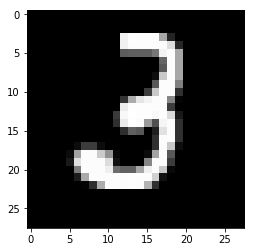

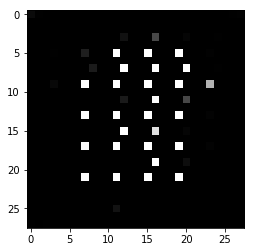

losses: 5.682645320892334, 0.004437536001205444
() ()
losses: 5.666802883148193, 0.006663079373538494
() ()
losses: 5.654391765594482, 0.004349584691226482
() ()
losses: 5.655689239501953, 0.005511473398655653
() ()
losses: 5.665860176086426, 0.030743982642889023
() ()
losses: 5.604840278625488, 0.005220502614974976
() ()
losses: 5.5607500076293945, 0.0045614526607096195
() ()
losses: 5.535775661468506, 0.004611377604305744
() ()
losses: 5.528655052185059, 0.0044713495299220085
() ()
losses: 5.538947105407715, 0.013089664280414581
() ()
losses: 5.536863327026367, 0.015437658876180649
() ()
losses: 5.510435581207275, 0.008302992209792137
() ()
losses: 5.491497039794922, 0.004687449429184198
() ()
losses: 5.49213981628418, 0.005046291742473841
() ()
losses: 5.50844144821167, 0.00557559821754694
() ()
losses: 5.5348920822143555, 0.004276731051504612
() ()
losses: 5.572080135345459, 0.00906217098236084
() ()
losses: 5.605102062225342, 0.003786144545301795
() ()
losses: 5.650650501251221, 0

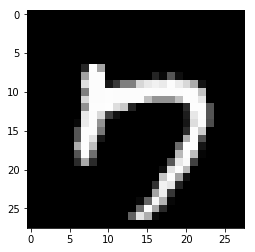

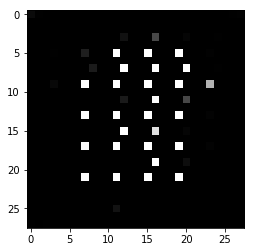

losses: 6.213067054748535, 0.002261012326925993
() ()
losses: 6.2733473777771, 0.0021651654969900846
() ()
losses: 6.334592342376709, 0.0021415906958281994
() ()
losses: 6.396204948425293, 0.0020551623310893774
() ()
losses: 6.457392692565918, 0.00290034431964159
() ()
losses: 6.515446662902832, 0.002125315135344863
() ()
losses: 6.572187900543213, 0.007349696941673756
() ()
losses: 6.610512733459473, 0.0014663602923974395
() ()
losses: 6.650791168212891, 0.0018174364231526852
() ()
losses: 6.690969467163086, 0.0017097167437896132
() ()
losses: 6.731111526489258, 0.012860314920544624
() ()
losses: 6.735958099365234, 0.0013523651286959648
() ()
losses: 6.744815349578857, 0.0016642758855596185
() ()
losses: 6.756507873535156, 0.0021580751053988934
() ()
losses: 6.769021987915039, 0.0035265523474663496
() ()
losses: 6.777237415313721, 0.006388604640960693
() ()
losses: 6.772682189941406, 0.002897531958296895
() ()
losses: 6.76780366897583, 0.0014584989985451102
() ()
losses: 6.76737785339

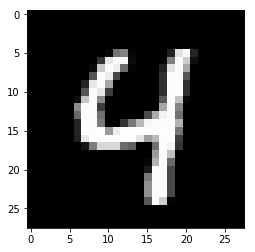

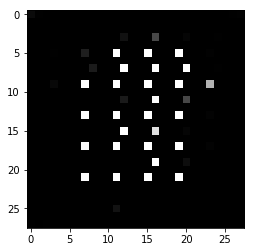

losses: 6.1594109535217285, 0.0035261204466223717
() ()
losses: 6.200333118438721, 0.004788617603480816
() ()
losses: 6.237375259399414, 0.0021301342640072107
() ()
losses: 6.279534339904785, 0.0028379340656101704
() ()
losses: 6.323149681091309, 0.0020018755458295345
() ()
losses: 6.370425224304199, 0.002179731149226427
() ()
losses: 6.419721603393555, 0.00198464747518301
() ()
losses: 6.469863414764404, 0.0028583621606230736
() ()
losses: 6.517343521118164, 0.0018968252697959542
() ()
losses: 6.565332889556885, 0.0019899241160601377
() ()
losses: 6.613041877746582, 0.001488970941863954
() ()
losses: 6.662137031555176, 0.005081809125840664
() ()
losses: 6.699472427368164, 0.0047450908459723
() ()
losses: 6.725759029388428, 0.0013645085273310542
() ()
losses: 6.75473690032959, 0.001352854073047638
() ()
losses: 6.785619258880615, 0.0013694318477064371
() ()
losses: 6.818045616149902, 0.0021614539436995983
() ()
losses: 6.849155426025391, 0.001178995706140995
() ()
losses: 6.88173675537

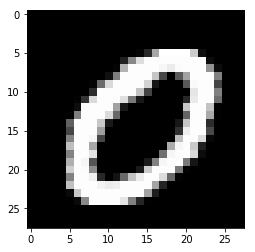

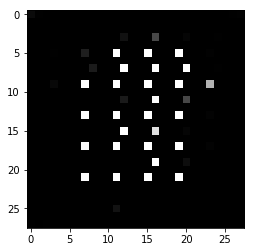

losses: 6.091923713684082, 0.0028461748734116554
() ()
losses: 6.110774040222168, 0.002362116938456893
() ()
losses: 6.138789176940918, 0.0025890041142702103
() ()
losses: 6.173472881317139, 0.002159932628273964
() ()
losses: 6.215252876281738, 0.0021802287083119154
() ()
losses: 6.262650489807129, 0.004487121477723122
() ()
losses: 6.305116176605225, 0.0019836858846247196
() ()
losses: 6.352362632751465, 0.001829995308071375
() ()
losses: 6.403580665588379, 0.0017035037744790316
() ()
losses: 6.458270072937012, 0.0026024342514574528
() ()
losses: 6.511334419250488, 0.0018464240711182356
() ()
losses: 6.565356731414795, 0.0016094602178782225
() ()
losses: 6.620204925537109, 0.00153694162145257
() ()
losses: 6.6750359535217285, 0.0019344231113791466
() ()
losses: 6.727895736694336, 0.015844523906707764
() ()
losses: 6.726273059844971, 0.0013117684284225106
() ()
losses: 6.730520248413086, 0.0016014066059142351
() ()
losses: 6.739045143127441, 0.0014726499794051051
() ()
losses: 6.751693

KeyboardInterrupt: ignored

In [59]:
for e in range(epochs):
    print(e)
    for idx, real_data in enumerate(data):
        train_step(real_data)
        if idx % 50 == 0:
            print(f'-------------------- {idx} --------------------')
            imshow(real_data[0])
            imshow(gz[0])